<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Experiments_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

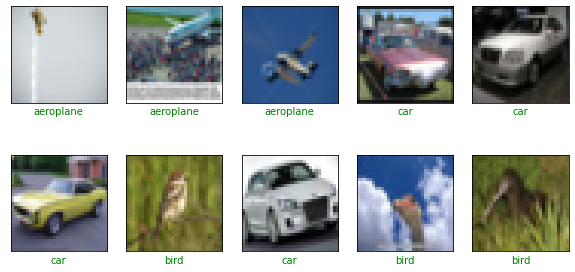

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [21]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [22]:
## Variation 2 - trained 
from time import perf_counter 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


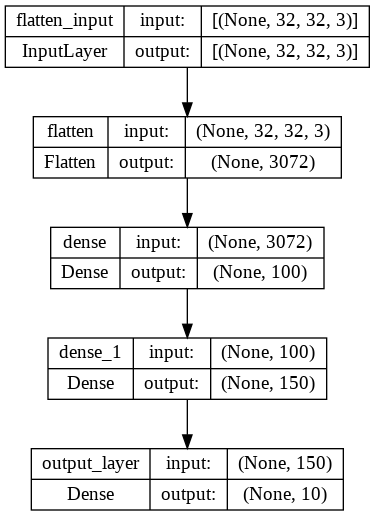

In [23]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [24]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
## Train 
time = perf_counter()

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 4ms/step - loss: 1.8698 - accuracy: 0.3242 - val_loss: 1.7565 - val_accuracy: 0.3652
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7045 - accuracy: 0.3896 - val_loss: 1.7032 - val_accuracy: 0.3916
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6307 - accuracy: 0.4170 - val_loss: 1.6633 - val_accuracy: 0.4016
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5909 - accuracy: 0.4315 - val_loss: 1.6620 - val_accuracy: 0.4036
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5499 - accuracy: 0.4448 - val_loss: 1.5681 - val_accuracy: 0.4266
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5204 - accuracy: 0.4574 - val_loss: 1.6030 - val_accuracy: 0.4176
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4985 - accuracy: 0.4647 - val_loss: 1.5454 - val_accuracy: 0.4390

In [26]:
time_1 = perf_counter() - time
print(time_1)

49.50249860399998


In [27]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model_1.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4671 - accuracy: 0.4797
Test acc: 0.480


##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [28]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 250)               25250     
                                                                 
 dense_4 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


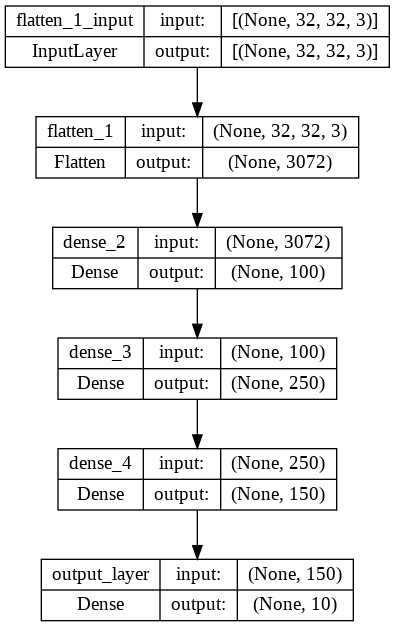

In [29]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [30]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [31]:
## Train 
time = perf_counter()

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8573 - accuracy: 0.3240 - val_loss: 1.7852 - val_accuracy: 0.3542
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6715 - accuracy: 0.3990 - val_loss: 1.6506 - val_accuracy: 0.3976
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6032 - accuracy: 0.4232 - val_loss: 1.6261 - val_accuracy: 0.4156
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5441 - accuracy: 0.4435 - val_loss: 1.5420 - val_accuracy: 0.4460
Epoch 5/200
704/704 [==============================] - 2s 4ms/step - loss: 1.5134 - accuracy: 0.4594 - val_loss: 1.5480 - val_accuracy: 0.4430
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4760 - accuracy: 0.4718 - val_loss: 1.5352 - val_accuracy: 0.4524
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4542 - accuracy: 0.4783 - val_loss: 1.5677 - val_accuracy: 0.4384

In [32]:
time_2 = perf_counter() - time
print(time_2)

49.77844258199997


In [33]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model_2.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4431 - accuracy: 0.4985
Test acc: 0.498


##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [34]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 384)              

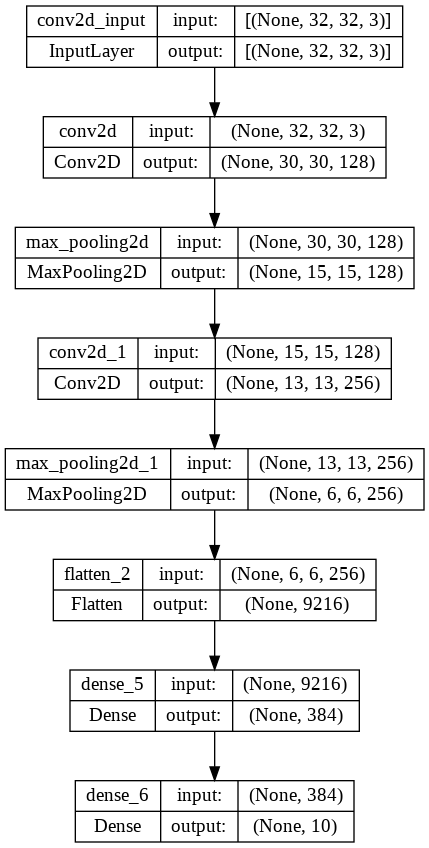

In [35]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [36]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
## Train 
time = perf_counter()

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 13s 11ms/step - loss: 2.1250 - accuracy: 0.2350 - val_loss: 1.9728 - val_accuracy: 0.2944
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8962 - accuracy: 0.2944 - val_loss: 1.7984 - val_accuracy: 0.3250
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7196 - accuracy: 0.3701 - val_loss: 1.6798 - val_accuracy: 0.3660
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.5626 - accuracy: 0.4236 - val_loss: 1.5100 - val_accuracy: 0.4270
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.4484 - accuracy: 0.4533 - val_loss: 1.4491 - val_accuracy: 0.4406
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.3641 - accuracy: 0.4805 - val_loss: 1.3582 - val_accuracy: 0.4714
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.2803 - accuracy: 0.5163 - val_loss: 1.2980 - val_accuracy

In [38]:
time_3 = perf_counter() - time
print(time_3)

188.17855576300002


In [39]:
## Evaluate

model_3 = tf.keras.models.load_model("CNN_model_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1937 - accuracy: 0.5469
Test acc: 0.547


##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [40]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), #Start of Layer 1
  MaxPool2D((2, 2),strides=2), #End of Layer 1
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 2
  MaxPool2D((2, 2),strides=2), #End of Layer 2
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 3
  MaxPool2D((2, 2),strides=2), #End of Layer 3
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax), # Classification
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

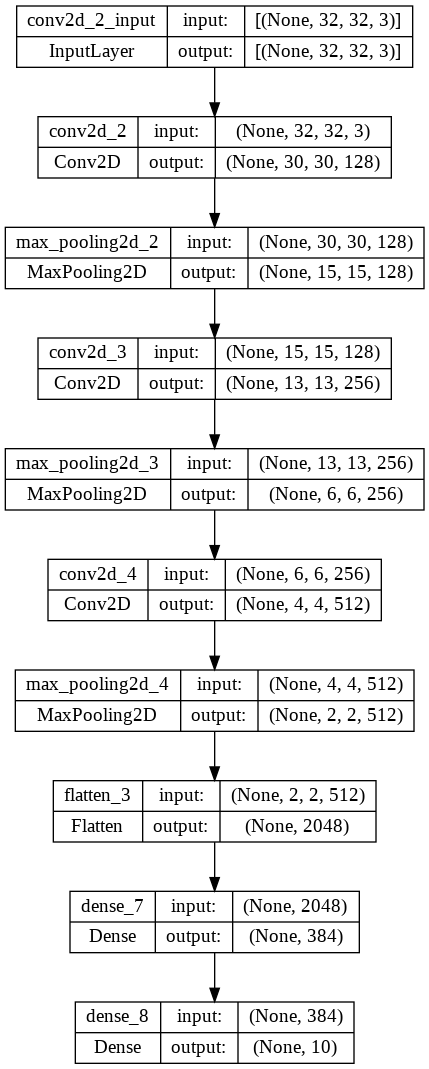

In [41]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [42]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
## Train
time = perf_counter()

history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 12ms/step - loss: 2.1873 - accuracy: 0.1784 - val_loss: 2.0782 - val_accuracy: 0.2084
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.9844 - accuracy: 0.2452 - val_loss: 1.9214 - val_accuracy: 0.2590
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 1.8232 - accuracy: 0.3254 - val_loss: 1.7318 - val_accuracy: 0.3704
Epoch 4/200
704/704 [==============================] - 8s 12ms/step - loss: 1.6358 - accuracy: 0.4134 - val_loss: 1.5562 - val_accuracy: 0.4602
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 1.4460 - accuracy: 0.4765 - val_loss: 1.4281 - val_accuracy: 0.4834
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 1.2985 - accuracy: 0.5096 - val_loss: 1.3058 - val_accuracy: 0.4998
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 1.1876 - accuracy: 0.5433 - val_loss: 1.2526 - val_accuracy:

In [44]:
time_4 = perf_counter() - time
print(time_4)

240.67180897000003


In [45]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 1.1421 - accuracy: 0.6066
Test acc: 0.607
